# Introduction

<p>Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

<h3> Objective </h3>
<p>To build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. </p>

<h3> Steps </h3> <a id="0"></a>

1. [Identify URL in the test and remove it](#1)
2. [Remove all punctuation](#2)
3. [Remove stop words (the, a, an, in, ...)](#3)
4. [Count unique words (collections)](#4)
5. [Splitting training and validation set](#5)
6. [Create word index](#6)
7. [Replacing text into series of number](#7)
8. [Make every sentences/ text same length](#8)
9. [Reversing keys values in word index dict, for decoding later](#9)
10. [Create LSTM model](#10)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
# Tokenize
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# create LSTM model
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
path = '/Users/Asus/Desktop/Unity Game/python/Data_Analysis/Text_Classification/dataset'

train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))
submission = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

## First glance of data

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


## Data shape

In [5]:
print(f'Shape of train data: {train.shape},\nShape of test data: {test.shape}')

Shape of train data: (7613, 5),
Shape of test data: (3263, 4)


## Missing data

In [6]:
print('Missing value count:')
train.isnull().sum()

Missing value count:


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

## Target distribution ratio

training dataset target (Disaster status) pie chart


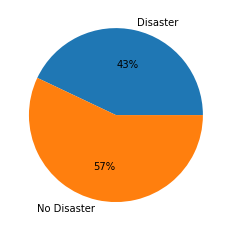

In [7]:
target_class = {'Disaster' :(train.target == 1).sum(), 'No Disaster': (train.target == 0).sum()}
print('training dataset target (Disaster status) pie chart')
plt.pie(data = target_class, labels=target_class.keys(), x=target_class.values(), autopct='%.0f%%')
plt.show()

## Text data preprocessing

In [8]:
print('Original text before preprocessing:')
train.text

Original text before preprocessing:


0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

<a id="1"></a>
### - Identify URL in the test and remove it

[Back to top](#0)

In [9]:
print('Original text with URL (first 5 text):')
[txt for txt in train.text if 'http:' in txt or 'www.' in txt][:5]

Original text with URL (first 5 text):


['@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C',
 'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw',
 '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi',
 'On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N',
 'INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA']

In [10]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

# for train dataset
train['text_cleaned'] = train.text.apply(lambda x: remove_url(x))
# for test dataset
test['text_cleaned'] = test.text.apply(lambda x: remove_url(x))

print('All the URL link has been removed')
[txt for txt in train.text_cleaned if 'http:' in txt or 'www.' in txt][:]

All the URL link has been removed


[]

<a id="2"></a>

### - Remove all punctuation

[Back to top](#0)

In [11]:
# train dataset
train['text_cleaned'] = train.text_cleaned.apply(lambda x: x.translate(x.maketrans('', '', string.punctuation)))
# test dataset
test['text_cleaned'] = test.text_cleaned.apply(lambda x: x.translate(x.maketrans('', '', string.punctuation)))
train['text_cleaned']

0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    ariaahrary TheTawniest The out of control wild...
7610                M194 0104 UTC5km S of Volcano Hawaii 
7611    Police investigating after an ebike collided w...
7612    The Latest More Homes Razed by Northern Califo...
Name: text_cleaned, Length: 7613, dtype: object

<a id="3"></a>
### - Remove stop words (<i>the</i>, <i>a</i>, <i>an</i>, <i>in</i>, ...)

[Back to top](#0)

In [12]:
#  get all the stop words
stop = set(stopwords.words('english'))
# remove it
train['text_cleaned'] = train.text_cleaned.apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in stop]))
test['text_cleaned'] = test.text_cleaned.apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in stop]))
train['text_cleaned']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                      m194 0104 utc5km volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text_cleaned, Length: 7613, dtype: object

<a id="4"></a>
### - Count unique words
[Back to top](#0)

<p> Using Counter from collection to count unique word</p>

In [13]:
def count_word(text):
    count = Counter()
    for txt in text:
        for word in txt.split():
            # save word and put in dict
            count[word] +=1
    return count
        
counter_train = count_word(train.text_cleaned)
counter_test = count_word(test.text_cleaned)
num_unique_word = len(counter_train)

print(f'Total number of words : {num_unique_word}')
print(f'Most common words found: {counter_train.most_common(5)}')

Total number of words : 17971
Most common words found: [('like', 345), ('im', 299), ('amp', 298), ('fire', 250), ('get', 229)]


<a id="5"></a>
## Splitting training and validation set
[Back to top](#0)

In [14]:
#  int to round off
train_size = int(train.shape[0] * 0.8)

# convert to numpy array
X_train = train.text_cleaned[:train_size].to_numpy()
y_train = train.target[:train_size].to_numpy()
X_valid = train.text_cleaned[train_size:].to_numpy()
y_valid = train.target[train_size:].to_numpy()
test_data = test.text_cleaned.to_numpy()

print(f'Training set shape: {len(X_train)}\nValidation set shape: {len(X_valid)}')

Training set shape: 6090
Validation set shape: 1523


<a id="6"></a>
## Vectorize a text corpus (truning text into sequence of integers)
 [Back to top](#0)

In [15]:
tokenizer = Tokenizer(num_words=num_unique_word)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
print('Word index dict:')
word_index

Word index dict:


{'like': 1,
 'amp': 2,
 'fire': 3,
 'im': 4,
 'get': 5,
 'via': 6,
 'new': 7,
 'people': 8,
 'news': 9,
 'dont': 10,
 'emergency': 11,
 'one': 12,
 '2': 13,
 'us': 14,
 'video': 15,
 'disaster': 16,
 'burning': 17,
 'body': 18,
 'would': 19,
 'buildings': 20,
 'police': 21,
 'crash': 22,
 'first': 23,
 'california': 24,
 'still': 25,
 'man': 26,
 'got': 27,
 'know': 28,
 'day': 29,
 'back': 30,
 'going': 31,
 'two': 32,
 'time': 33,
 'full': 34,
 'accident': 35,
 'see': 36,
 'world': 37,
 'attack': 38,
 'nuclear': 39,
 'youtube': 40,
 'may': 41,
 'love': 42,
 'go': 43,
 'rt': 44,
 'many': 45,
 'cant': 46,
 '3': 47,
 'watch': 48,
 'collapse': 49,
 'dead': 50,
 'today': 51,
 'car': 52,
 'mass': 53,
 'want': 54,
 'years': 55,
 'work': 56,
 'train': 57,
 'last': 58,
 'good': 59,
 'think': 60,
 'families': 61,
 'hiroshima': 62,
 'life': 63,
 'fires': 64,
 'best': 65,
 'could': 66,
 'say': 67,
 'u': 68,
 'death': 69,
 'hot': 70,
 'forest': 71,
 'way': 72,
 'killed': 73,
 'need': 74,
 'legion

<a id="7"></a>
### - replacing text into series of number
[Back to top](#0)

In [16]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_valid_sequences = tokenizer.texts_to_sequences(X_valid)
test_sequences = tokenizer.texts_to_sequences(test_data)

X_train_sequences[:5]

[[3739, 696, 235, 41, 1282, 3740, 14],
 [71, 3, 129, 576, 5670, 5671, 1283],
 [1448, 1186, 1882, 495, 5672, 1449, 116, 1882, 495, 976, 1187],
 [2243, 8, 3741, 1070, 116, 976, 24],
 [27, 1071, 358, 5673, 1635, 892, 1070, 5674, 91]]

In [17]:
train.text_cleaned[:5]

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3    13000 people receive wildfires evacuation orde...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text_cleaned, dtype: object

<a id="8"></a>
### - Make every sentences/ text same length
[Back to top](#0)

In [18]:
max_text_len = max([len(txt) for txt in X_train_sequences])

# padding and truncating for numbering position
train_padded = pad_sequences(X_train_sequences, maxlen=max_text_len, padding='post', truncating='post')
valid_padded = pad_sequences(X_valid_sequences, maxlen=max_text_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_text_len, padding='post', truncating='post')

print(f'train_padded shape: {train_padded.shape}\nvalid_padded shape: {valid_padded.shape}')
train_padded[0]

train_padded shape: (6090, 25)
valid_padded shape: (1523, 25)


array([3739,  696,  235,   41, 1282, 3740,   14,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

<a id="9"></a>
### - Reversing keys values in word index dict, for decoding later
[Back to top](#0)

In [19]:
reverse_word_index = dict((val, key) for key, val in word_index.items())

# get in dict: with 2nd parameter, if there is no such seq, return ?
def decode(seq):
    return ' '.join([reverse_word_index.get(s, '?') for s in seq])

<a id="10"></a>
## Create LSTM model
[Back to top](#0)

<a href="https://www.tensorflow.org/text/guide/word_embeddings">Tensorflow Word Embeddings link</a>
<p>Give an efficient, dense representation in which similar words have a similar encoding</p>

In [20]:
model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_word, 32, input_length=max_text_len))
# Take input as integer matrix of size (batch, input_length)
# Largest integer (word index) in input should not be larger than num_words (vocabulary size)
#  output shape is (batch_dimension, input_length, 32)

# 64 number of output, dropout is 10%
model.add(layers.LSTM(64, dropout=0.1))
#  Dense with 1 output in the end with sigmoid function
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 32)            575072    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 599,969
Trainable params: 599,969
Non-trainable params: 0
_________________________________________________________________


In [21]:
# from_logits=False as we already specify sigmoid function
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics=['accuracy']

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [22]:
model.fit(train_padded, y_train, epochs=20, validation_data=(valid_padded, y_valid), verbose=2)

Epoch 1/20
191/191 - 7s - loss: 0.5525 - accuracy: 0.7108 - val_loss: 0.4523 - val_accuracy: 0.7997
Epoch 2/20
191/191 - 4s - loss: 0.2980 - accuracy: 0.8833 - val_loss: 0.5221 - val_accuracy: 0.7820
Epoch 3/20
191/191 - 3s - loss: 0.1667 - accuracy: 0.9476 - val_loss: 0.6548 - val_accuracy: 0.7249
Epoch 4/20
191/191 - 3s - loss: 0.1160 - accuracy: 0.9649 - val_loss: 0.6284 - val_accuracy: 0.7485
Epoch 5/20
191/191 - 3s - loss: 0.0976 - accuracy: 0.9719 - val_loss: 0.6056 - val_accuracy: 0.7643
Epoch 6/20
191/191 - 3s - loss: 0.0835 - accuracy: 0.9768 - val_loss: 0.8354 - val_accuracy: 0.7584
Epoch 7/20
191/191 - 3s - loss: 0.0699 - accuracy: 0.9783 - val_loss: 0.7934 - val_accuracy: 0.7485
Epoch 8/20
191/191 - 3s - loss: 0.0591 - accuracy: 0.9801 - val_loss: 0.8946 - val_accuracy: 0.7413
Epoch 9/20
191/191 - 3s - loss: 0.0430 - accuracy: 0.9823 - val_loss: 1.0431 - val_accuracy: 0.7413
Epoch 10/20
191/191 - 3s - loss: 0.0445 - accuracy: 0.9800 - val_loss: 1.0307 - val_accuracy: 0.7459

## Confusion matrix

In [23]:
val_pred = model.predict(valid_padded)
val_out = [1 if p > 0.5 else 0 for p in val_pred]
print('Confusion Matrix:\n', confusion_matrix(y_valid, val_out))
print(f'F1 score: {f1_score(y_valid, val_out):.2f}')
print(f'Accuracy score: {accuracy_score(y_valid, val_out):.2f}')

Confusion Matrix:
 [[629 185]
 [221 488]]
F1 score: 0.71
Accuracy score: 0.73


In [24]:
prediction = model.predict(test_padded)
# round off to 0 or 1
result =[1 if p > 0.5 else 0 for p in prediction]

In [25]:
for txt, target in zip(test.text_cleaned[20:30], result[20:30]):
    print(txt, f'. target: {target}')

beware world ablaze sierra leone amp guap . target: 0
burning man ablaze turban diva via etsy . target: 0
diss song people take 1 thing run smh eye opener though 2 set game ablaze cyhitheprynce . target: 0
rape victim dies sets ablaze 16yearold girl died burn injuries set ablazeû . target: 1
setting ablaze . target: 0
ctvtoronto bins front field house wer set ablaze day flames went rite hydro pole wonder . target: 1
nowplaying alfons ablaze 2015 puls radio pulsradio . target: 0
burning rahm lets hope city hall builds giant wooden mayoral effigy 100 feet tall amp sets ablaze johnkass . target: 0
philippaeilhart dhublath hurt eyes ablaze insulted anger . target: 0
accident cleared paturnpike patp eb pa18 cranberry slow back traffic . target: 1


## Submission

In [26]:
submission['target'] = result
submission.to_csv(os.path.join(path, 'first_submission.csv'), index=False)